# #important

In [1]:
!git clone https://github.com/sofiyabogakovskaya/HopfieldAM

Cloning into 'HopfieldAM'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 474 (delta 57), reused 94 (delta 34), pack-reused 349 (from 1)
Receiving objects: 100% (474/474), 3.37 MiB | 13.69 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 900 bytes | 225.00 KiB/s, done.
From https://github.com/sofiyabogakovskaya/HopfieldAM
   2029fbc..c3a62ef  main       -> origin/main
Updating 2029fbc..c3a62ef
Fast-forward
 utils/create_gif.py | 36 ++++++++++++++++++++++++++++++++++++
 1 file changed, 36 insertions(+)


In [3]:
# !pip install -r HopfieldAM/requirements.txt
# !pip install -r requirements.txt

!pip install rootutils

!touch /content/HopfieldAM/.project-root

import os
import rootutils

rootutils.setup_root(os.path.abspath('/content/HopfieldAM'), indicator=".project-root", pythonpath=True, dotenv=True, cwd=True)

PosixPath('/content/HopfieldAM')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-4"

In [7]:
import shutil
from argparse import Namespace

from typing import Callable, Optional, Tuple, Dict

import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as random
from jax import vmap, jit, jvp
import equinox as eqx
import optax
import numpy as np

import tensorflow_datasets as tfds

from IPython.display import HTML

from utils.config import CONFIG
from utils.activation_map import ACTIVATION_MAP
from models import get_model
from losses import get_batch_loss
from datasets.dataset_loader import get_dataloader
from datasets.get_dimension import get_dimension
from src.train import train
from src.test import test
from utils.visualization import plot_metrics, plot_energy, plot_energy_dot, create_batch_to_compute_energy
from utils.integrate_trajectory import integrate_trajectory, get_energy
from utils.logger import new_run_id, log_experiment, log_summary
from utils.parse_config import parse_config
from utils.for_inference import get_best_checkpoint_path, load_best_model

from utils.trajectory_length import trajectory_direction, trajectory_length
from utils.create_custom_batch import create_custom_batch
from utils.trajectory_curvature import derivative_based_curvature
from utils.create_gif import create_gif

from tqdm.auto import tqdm
import os
import glob
import re

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# import tensorflow as tf

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)


# model of choice right now is relu | dt = 0.01 | t1 = 15.0

In [8]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "tanh",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)

best_model = load_best_model(
    args,
    experiments_dir=experiments_dir
  )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.Z87A7P_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.Z87A7P_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [9]:
key = random.PRNGKey(19)

In [10]:
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

---
# restore stationary states

In [11]:
from jax import lax

In [12]:

def find_fixed_point(W, b, x0, max_iters=200, tol=1e-6):
    """
    Solve x = W tanh(x) + b using fixed-point iteration.
    """
    def F(x):
        return W @ jnp.tanh(x) + b

    def body_fun(val):
        i, x, x_prev = val
        x_new = F(x)
        return i+1, x_new, x

    def cond_fun(val):
        i, x, x_prev = val
        return jnp.logical_and(i < max_iters,
                               jnp.linalg.norm(x - x_prev) > tol)

    _, x_final, _ = lax.while_loop(
        cond_fun, body_fun, (0, x0, x0 + 10.0)  # x_prev != x0 initially
    )
    return x_final

In [17]:
def show_image(vec):
    img = vec.reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.show()

In [43]:
# TODO: doesn't work when nt zeros idk
X, y = create_custom_batch(key,
                    numbers = [0],
                    each_number_samples=2)
x0 = X[0]

In [44]:
type(x0)

jaxlib._jax.ArrayImpl

In [55]:
x0 = jnp.ones(784)

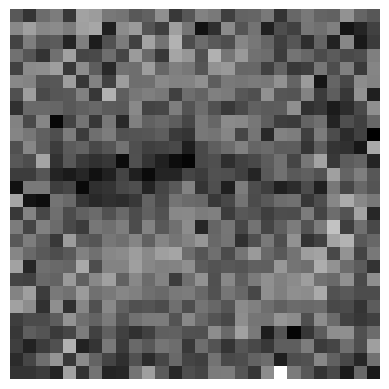

In [56]:
x_final = find_fixed_point(best_model.W, best_model.b, x0)
show_image(x_final)

In [29]:
def anderson(F, x0, m=5, max_iters=50, tol=1e-5):
    """
    Anderson acceleration for solving x = F(x).
    F should be a JAX-jittable function.
    """
    def init_state():
        X = jnp.tile(x0, (m, 1))
        G = jnp.tile(F(x0), (m, 1))
        return {
            "x": x0,
            "X": X,
            "G": G,
            "iter": 0,
        }

    def body(state):
        x = state["x"]
        f_x = F(x)

        X = state["X"]
        G = state["G"]
        k = jnp.minimum(state["iter"], m-1)

        # Update history
        X = X.at[1:].set(X[:-1])
        G = G.at[1:].set(G[:-1])
        X = X.at[0].set(x)
        G = G.at[0].set(f_x)

        # Solve least squares for Anderson coefficients
        dX = X[:k] - X[k]
        dG = G[:k] - G[k]
        mat = dG - dX  # residual differences
        rhs = f_x - x

        coef, _, _, _ = jnp.linalg.lstsq(mat.T, rhs, rcond=None)
        coef = jnp.pad(coef, (0, m - 1 - k))

        x_new = f_x - (mat.T @ coef)

        return {
            "x": x_new,
            "X": X,
            "G": G,
            "iter": state["iter"] + 1,
        }

    def cond(state):
        x = state["x"]
        f_x = F(x)
        return jnp.logical_and(
            jnp.linalg.norm(f_x - x) > tol,
            state["iter"] < max_iters
        )

    state = init_state()
    state = lax.while_loop(cond, body, state)
    return state["x"]


In [30]:
W = best_model.W
b = best_model.b
F = lambda x: W @ jnp.tanh(x) + b
x0 = jnp.zeros(784)

x_star = anderson(F, x0)

IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(None, JitTracer<~int32[]>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

---
# let's look what's happening with trajectories for different numbers:

In [ ]:
d = {}
for i in range(10):
    X, y = create_custom_batch(key,
                       numbers = [i],
                      each_number_samples=10)
    traj_lengths = []
    traj_dirs = []
    diffs = []
    for x in X:
        X_traj = integrate_trajectory(best_model, x, args.dt, args.t1, ts)
        traj_length = trajectory_length(X_traj)
        traj_lengths.append(traj_length)
        traj_dir = trajectory_direction(X_traj)
        traj_dirs.append(traj_dir)
        diffs.append(traj_length - traj_dir)
    d[f'traj_length_{i}'] = traj_lengths
    d[f'traj_dirs_{i}'] = traj_dirs

df = pd.DataFrame(data=d)
df

,traj_length_0,traj_dirs_0,traj_length_1,traj_dirs_1,traj_length_2,traj_dirs_2,traj_length_3,traj_dirs_3,traj_length_4,traj_dirs_4,traj_length_5,traj_dirs_5,traj_length_6,traj_dirs_6,traj_length_7,traj_dirs_7,traj_length_8,traj_dirs_8,traj_length_9,traj_dirs_9
0,8404.783,3383.3762,12598.578,11144.825,5889.0947,2535.726,6533.2856,4396.923,5064.303,2252.0547,5773.265,2453.8394,6433.0938,3788.9695,6789.9946,4080.2234,5085.443,2039.9258,5560.4204,2499.6802
1,4987.92,2458.5564,8781.273,7099.0493,6262.212,2488.9297,8022.154,5697.9673,4996.4443,2070.5608,7414.1323,3910.5757,5895.458,2425.2065,4511.9927,1809.4924,6455.803,3116.5334,5846.117,2463.3774
2,7583.0537,3445.7273,9773.856,8406.724,6994.8564,3989.937,6915.3877,4600.3525,6821.495,2898.7742,7604.6978,3742.311,5401.8267,2499.3083,4794.432,2321.492,7556.0146,3211.917,4460.4404,2017.3793
3,6782.178,2947.074,13121.239,11564.32,7429.417,3019.212,7254.2744,4908.2847,6249.644,2567.011,6287.7686,2705.602,6093.422,2500.7493,4000.8867,1566.73,6745.591,3008.105,6577.313,2709.1536
4,7120.8247,3358.9526,11512.824,9800.714,5742.6797,3167.3445,5014.3945,2832.0977,5082.435,2029.0029,5658.098,2076.64,5530.986,2543.2375,6186.683,3890.2007,6619.926,3087.246,5847.1704,2335.7578
5,5861.0156,2577.0999,9056.98,6222.1284,5161.3125,2478.8738,7529.3916,4849.9385,4912.1226,2318.7065,6179.8706,2951.2253,5349.1963,2873.7114,5665.0586,2454.353,5360.321,2349.398,5015.963,2985.1243
6,7136.411,3329.8123,13656.874,12195.771,3512.3997,1638.7108,6989.4404,3187.8364,5025.204,1925.4327,10509.008,8284.392,5343.614,2777.5803,6269.17,2416.634,6790.8027,3109.3752,4992.448,2422.7039
7,6381.2803,2772.4375,20261.105,18965.541,6887.861,2897.6702,6355.705,3946.3677,5393.9556,2469.809,5199.9463,2181.6577,8185.286,5240.022,5324.1724,2608.2239,5644.202,2432.6584,5881.7056,2599.8457
8,8182.374,3875.9395,8486.646,7056.7524,8035.4595,4137.1577,6829.5664,4197.68,6330.3843,2798.5793,7814.373,3890.074,5761.0776,3370.6365,4721.5596,2019.4503,6594.008,2885.1362,6602.18,2872.6853
9,6843.955,2775.8574,21606.604,20494.857,5265.1177,2053.0444,6376.678,2569.3162,5493.3857,2323.4524,8010.5186,4550.7593,8037.0635,5378.3584,5745.6323,2446.9392,4859.5454,2060.4749,5832.0356,2396.9006


Trajectories aren't straight (except for 1's, they don't seem to change much), but shouldn't be that curvy, lenghth is mostly 2-3 times bigger then the direction $|x_0 - x_T|$. But still let's measure the curvature over time

---
#Let's try to learn something about the curvature of the trajectories.

In [ ]:
X, y = create_custom_batch(key,
                    numbers = [0],
                    each_number_samples=10)

In [ ]:
x_0 = X[0]

In [ ]:
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

In [ ]:
x_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
traj_length = trajectory_length(x_traj)
traj_dir = trajectory_direction(x_traj)

In [ ]:
print(traj_length, traj_dir)

8404.783 3383.3762


below just wanted to test two methods of measuring curvature. the classic one (deriviative based is better, less noisy)

In [ ]:
out1 = derivative_based_curvature(x_traj, args.dt)
out2 = triangle_based_curvature(x_traj, args.dt)

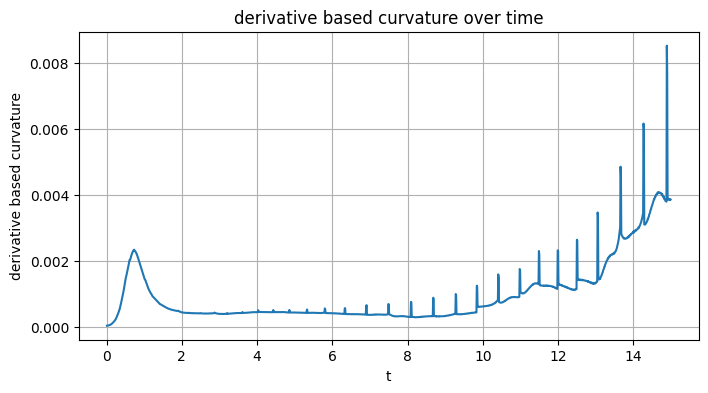

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ts, out1)
plt.xlabel("t")
plt.ylabel("derivative based curvature")
plt.title("derivative based curvature over time")
plt.grid(True)
plt.show()

even 0.008 is a very slight curvature

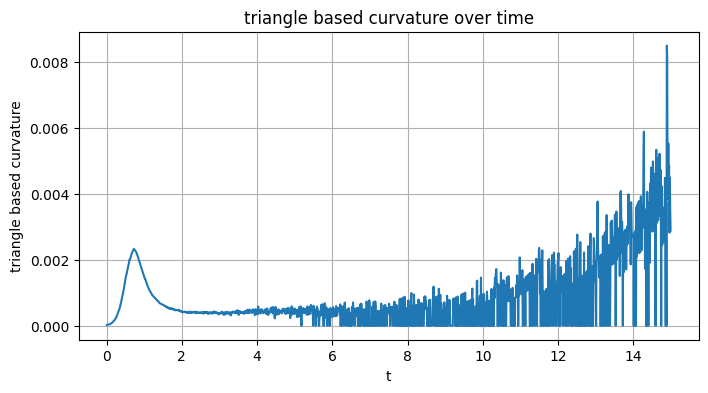

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ts, out2)
plt.xlabel("t")
plt.ylabel("triangle based curvature")
plt.title("triangle based curvature over time")
plt.grid(True)
plt.show()

### we can observe other information abt curves, like how the vector length changes over time, also module of the derivative of the curve

In [ ]:
x_vec_lengh_over_t = jnp.linalg.norm(x_traj, axis=-1)

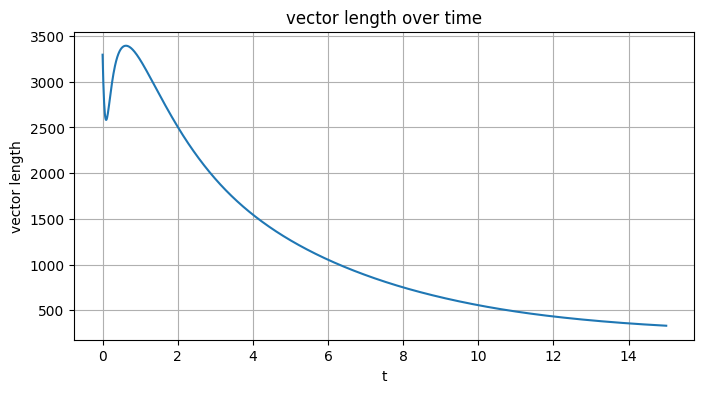

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ts, x_vec_lengh_over_t)
plt.xlabel("t")
plt.ylabel("vector length")
plt.title("vector length over time")
plt.grid(True)
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-1203148432.py:9: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("|\dot{x_traj}|")
/tmp/ipython-input-1203148432.py:10: SyntaxWarning: invalid escape sequence '\d'
  plt.title("|\dot{x_traj}| over time")


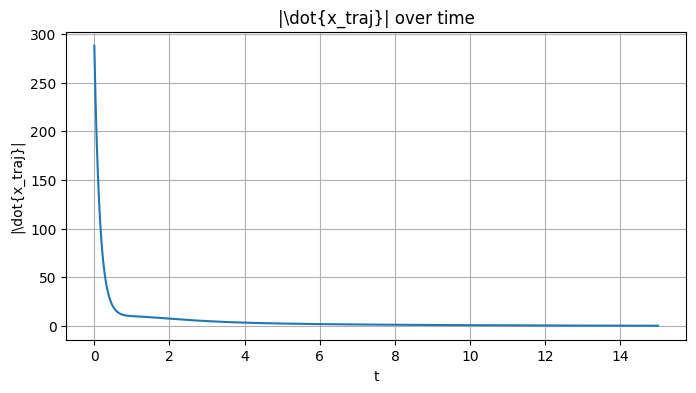

In [ ]:
diffs = jnp.diff(x_traj, axis=0)
step_norms = jnp.linalg.norm(diffs, axis=-1)

ts1 = jnp.linspace(0.0, args.t1, N_steps)

plt.figure(figsize=(8, 4))
plt.plot(ts1, step_norms)
plt.xlabel("t")
plt.ylabel("|\dot{x_traj}|")
plt.title("|\dot{x_traj}| over time")
plt.grid(True)
plt.show()

---
## below tried to make an animation of how the initial picture changes over time

might be useful in future?

for create_gif added an opportunity to save colors, means black on the white and black on all the stages of evolution are the same black and white as on the initial images (at least it should be so)

In [ ]:
from IPython.display import HTML

In [ ]:
X, y = create_custom_batch(key,
                    numbers = [1],
                    each_number_samples=10)

x_0 = X[0]
x_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)

In [ ]:
anim = create_gif(x_traj, out_path="example_mnist_evolution.gif", fps=30, save_colors = True, sample_stride=3)
HTML(anim.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

---
# another curvature function test

In [ ]:
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

In [ ]:
X, y = create_custom_batch(key,
                    numbers = [0],
                    each_number_samples=10)
x_0 = X[0]
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

In [ ]:
X_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
traj_length = trajectory_length(X_traj)
traj_dir = trajectory_direction(X_traj)

In [ ]:
def derivative_based_curvature_(model: Callable,
                                X_traj: jnp.ndarray,
                                dt: float,
                                t1: float
                                ) -> Tuple[jnp.ndarray, Dict]:

    N_steps = int(t1 / dt)
    ts = jnp.linspace(0.0, t1, N_steps + 1)
    ts = jnp.asarray(ts)

    def model_wrapped(ti, xi):
        return model(ti, xi, None)

    V = vmap(model_wrapped)(ts, X_traj) # (T,N)

    # JVP acceleration (we use the chai rule to calculate the accelaration)
    def acceleration(ti, xi, vi):
        z = jnp.concatenate([xi, jnp.array([ti])])
        dz = jnp.concatenate([vi, jnp.array([1.0])])
        def F(zflat):
            x_ = zflat[:-1]
            t_ = zflat[-1]
            return model_wrapped(t_, x_)
        _, a = jvp(F, (z,), (dz,))
        return a

    acceleration_jit = jit(acceleration)

    A = vmap(acceleration_jit)(ts, X_traj, V)   # (T, N)

    # curvature: kappa = || a_perp || / ||v||^2
    V_square = jnp.sum(V * V, axis=1)   # (T,)
    dot_VA = jnp.sum(V * A, axis=1)   # (T,)

    projection = (dot_VA / V_square)[:, None] * V   # (T, N)
    A_perp = A - projection
    A_perp_norm = jnp.linalg.norm(A_perp, axis=1)

    kappa = A_perp_norm / V_square

    return kappa

In [ ]:
kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

In [ ]:
%timeit derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

173 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


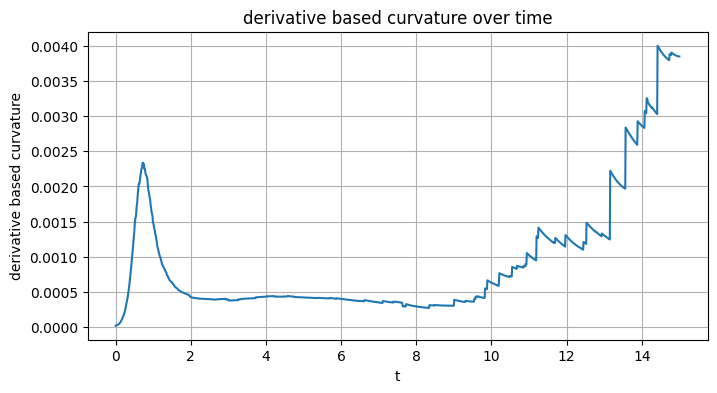

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ts, kappa)
plt.xlabel("t")
plt.ylabel("derivative based curvature")
plt.title("derivative based curvature over time")
plt.grid(True)
plt.show()

In [ ]:
kappa2 = derivative_based_curvature(X_traj, args.dt)

In [ ]:
%timeit derivative_based_curvature(X_traj, args.dt)

7.37 ms ± 882 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


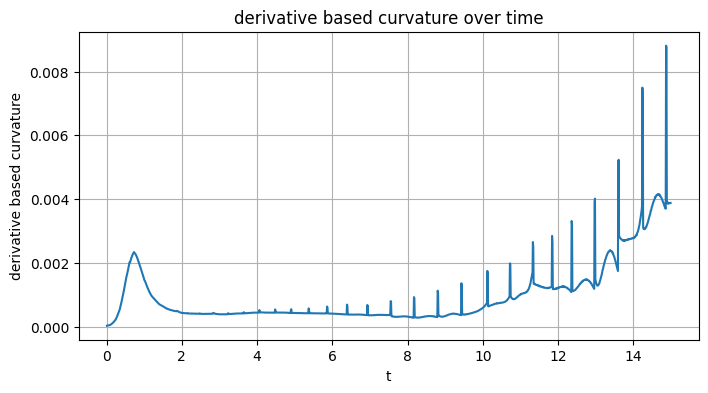

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(ts, kappa2)
plt.xlabel("t")
plt.ylabel("derivative based curvature")
plt.title("derivative based curvature over time")
plt.grid(True)
plt.show()

---
#let's try to compare different activation functions

In [ ]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

In [ ]:
X, y = create_custom_batch(key,
                    numbers = [0],
                    each_number_samples=5)
x_0 = X[0]

## go through different activations

dt = 0.01, t1 = 1.0
for t1 = 1.0:
traj_dir = 62635.48828125
traj_length = 64177.7109375


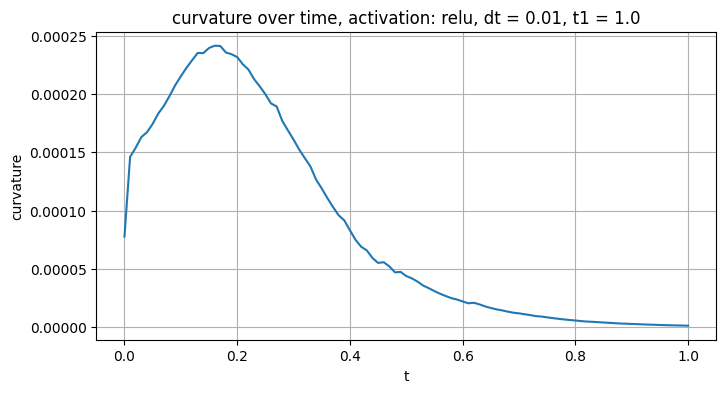

for t1 = 1.0:
traj_dir = 24458.052734375
traj_length = 25356.015625


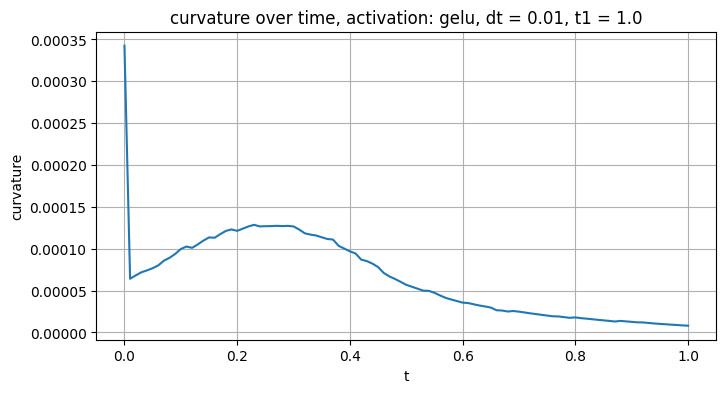

for t1 = 1.0:
traj_dir = 1317.4058837890625
traj_length = 1318.755859375


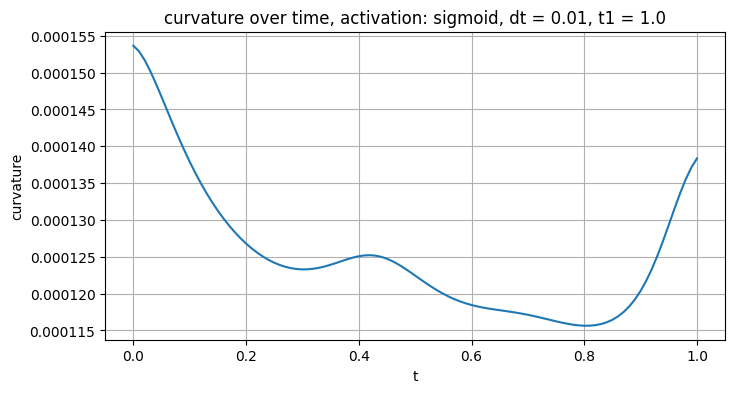

for t1 = 1.0:
traj_dir = 193744.28125
traj_length = 194201.34375


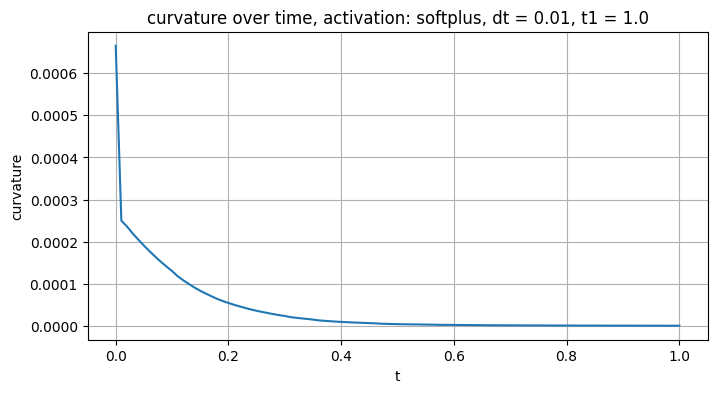

for t1 = 1.0:
traj_dir = 1302.8778076171875
traj_length = 1305.0030517578125


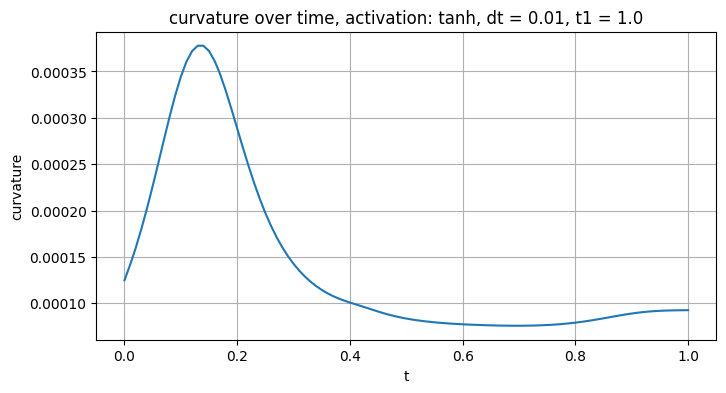

In [ ]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "relu",
    dt=0.01,
    t1=1.0,
    N_classes=10,
)

print(f"dt = {args.dt}, t1 = {args.t1}")

activations = ['relu', 'gelu', 'sigmoid', 'softplus', 'tanh']
for a in activations:
    args.activation = a
    best_model = load_best_model(args,experiments_dir=experiments_dir)

    N_steps = int(args.t1 / args.dt)
    ts = jnp.linspace(0.0, args.t1, N_steps + 1)

    X_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
    traj_length = trajectory_length(X_traj)
    traj_dir = trajectory_direction(X_traj)
    print(f"for t1 = {args.t1}:")
    print(f"traj_dir = {traj_dir}")
    print(f"traj_length = {traj_length}")

    kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

    plt.figure(figsize=(8, 4))
    plt.plot(ts, kappa)
    plt.xlabel("t")
    plt.ylabel("curvature")
    plt.title(f"curvature over time, activation: {args.activation}, dt = {args.dt}, t1 = {args.t1}")
    plt.grid(True)
    plt.show()

## iterating relu models over time (t1)

activation: relu, dt = 0.01
for t1 = 1.0:
traj_dir = 44598.65234375
traj_length = 45948.85546875


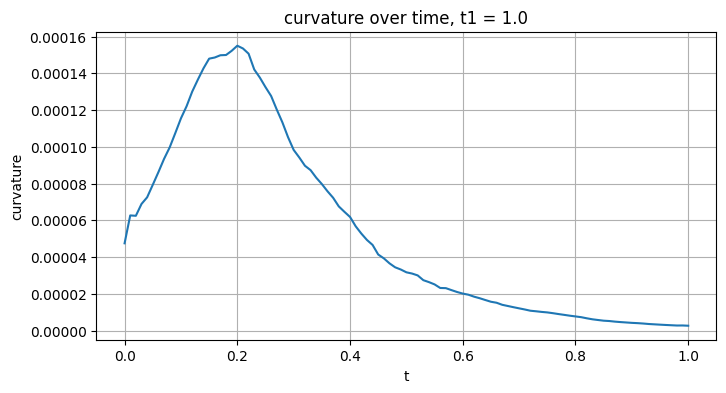

for t1 = 3.0:
traj_dir = 80905.75
traj_length = 82298.484375


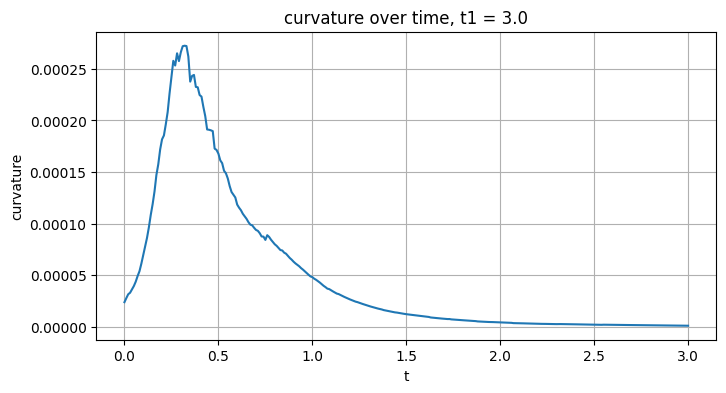

for t1 = 5.0:
traj_dir = 22952.068359375
traj_length = 24461.64453125


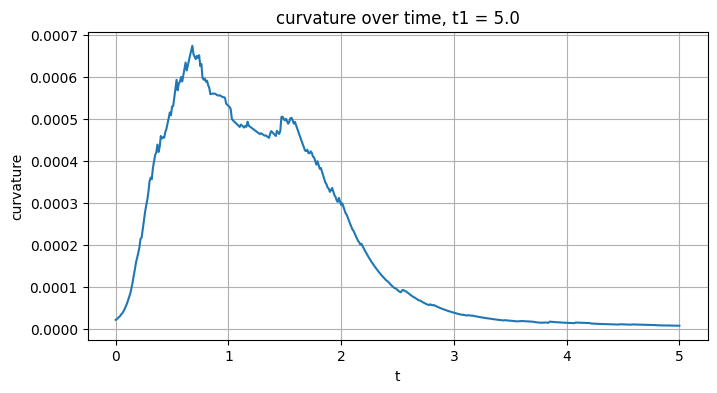

for t1 = 10.0:
traj_dir = 4555.54833984375
traj_length = 8412.2216796875


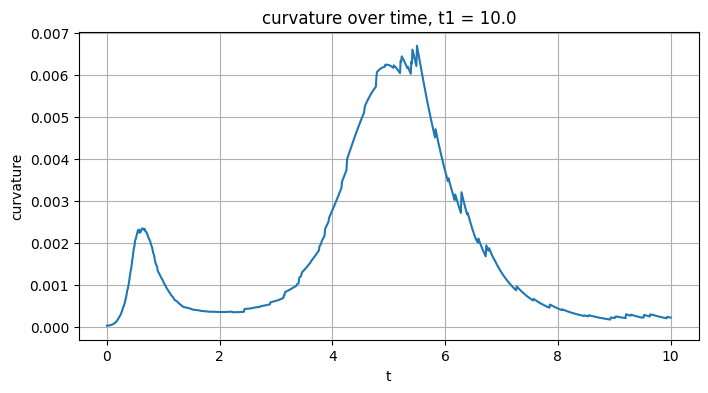

for t1 = 15.0:
traj_dir = 3383.369384765625
traj_length = 8404.7958984375


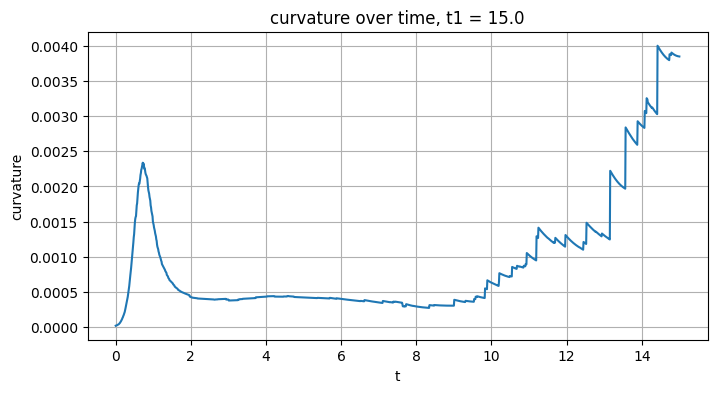

In [ ]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "relu",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)

print(f"activation: {args.activation}, dt = {args.dt}")

times = [1.0, 3.0, 5.0, 10.0, 15.0]
for t1_ in times:
    args.t1 = t1_
    best_model = load_best_model(args,experiments_dir=experiments_dir)

    N_steps = int(args.t1 / args.dt)
    ts = jnp.linspace(0.0, args.t1, N_steps + 1)

    X_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
    traj_length = trajectory_length(X_traj)
    traj_dir = trajectory_direction(X_traj)
    print(f"for t1 = {args.t1}:")
    print(f"traj_dir = {traj_dir}")
    print(f"traj_length = {traj_length}")

    kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

    plt.figure(figsize=(8, 4))
    plt.plot(ts, kappa)
    plt.xlabel("t")
    plt.ylabel("curvature")
    plt.title(f"curvature over time, t1 = {args.t1}")
    plt.grid(True)
    plt.show()


## iterating sigmoid models over time (t1)

activation: sigmoid, dt = 0.01
for t1 = 1.0:
traj_dir = 2062.754638671875
traj_length = 2063.280029296875


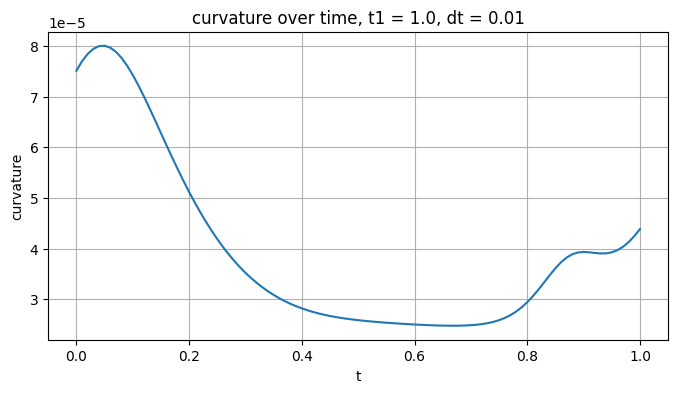

for t1 = 1.0:
traj_dir = 2064.153564453125
traj_length = 2064.661865234375


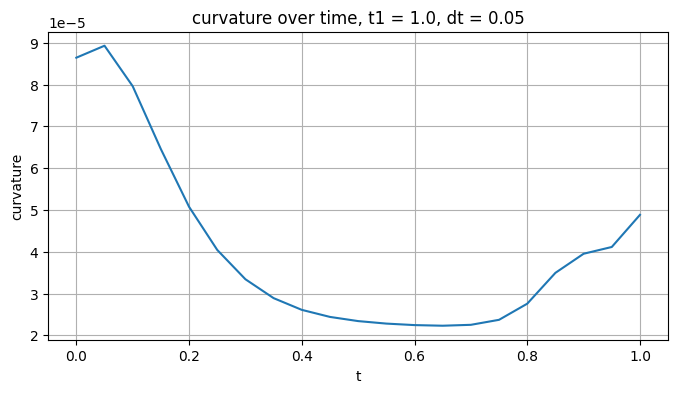

for t1 = 1.0:
traj_dir = 2061.87548828125
traj_length = 2062.38232421875


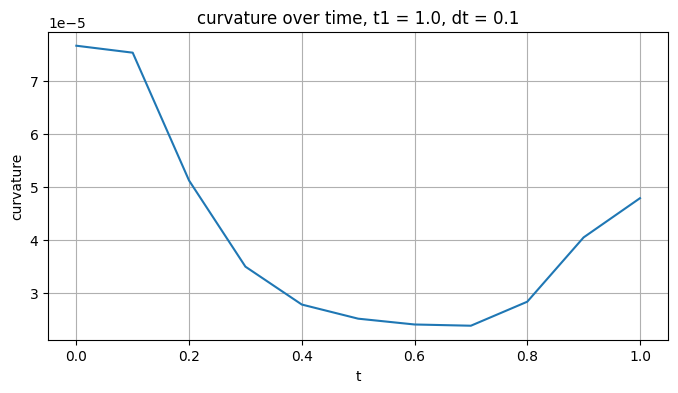

for t1 = 3.0:
traj_dir = 3138.322998046875
traj_length = 3139.0107421875


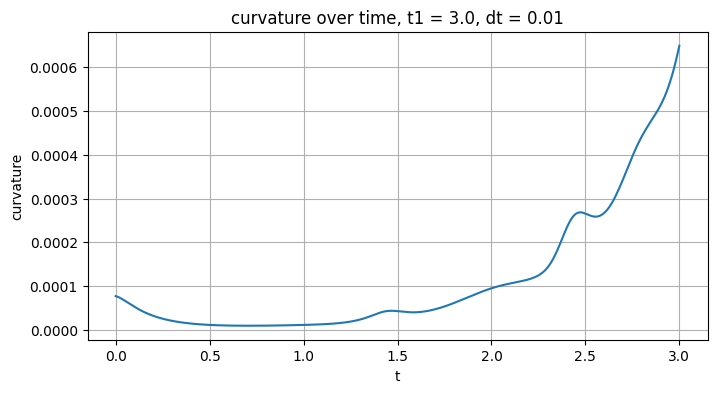

for t1 = 3.0:
traj_dir = 3143.7666015625
traj_length = 3144.53955078125


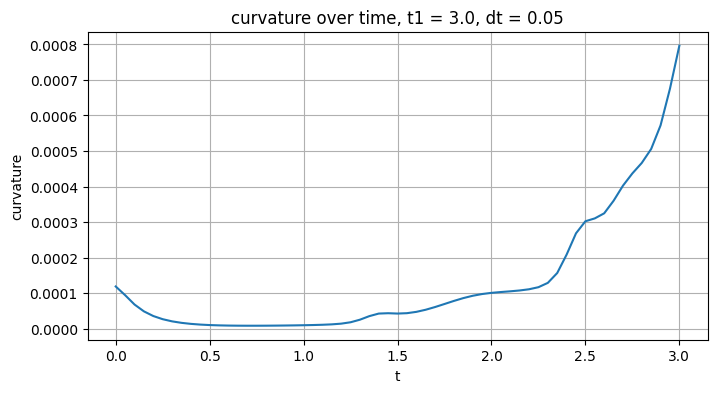

for t1 = 3.0:
traj_dir = 3146.780029296875
traj_length = 3147.509521484375


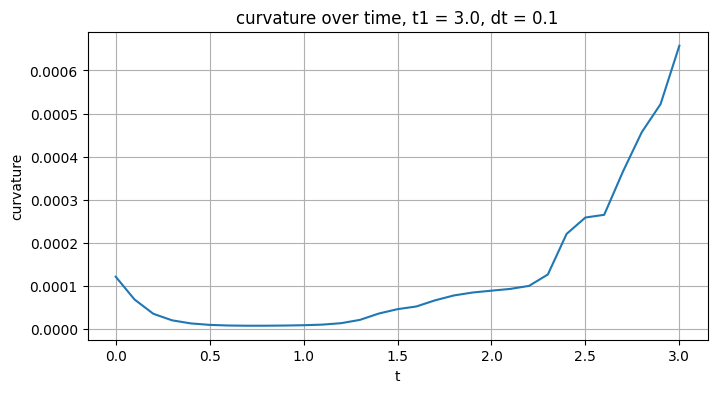

for t1 = 5.0:
traj_dir = 3288.98193359375
traj_length = 3295.99365234375


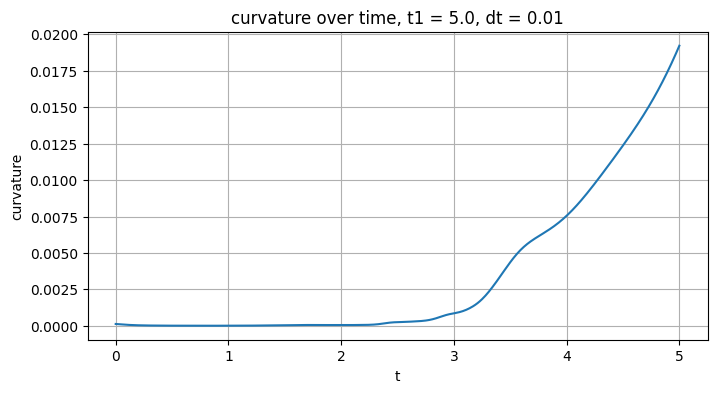

for t1 = 5.0:
traj_dir = 3288.463134765625
traj_length = 3295.5703125


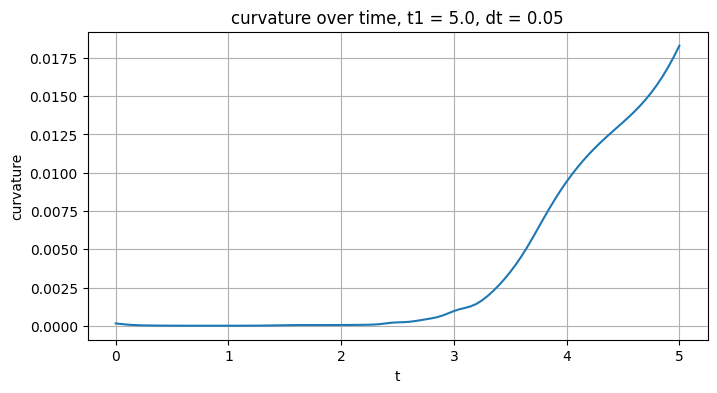

for t1 = 5.0:
traj_dir = 3294.519775390625
traj_length = 3303.90185546875


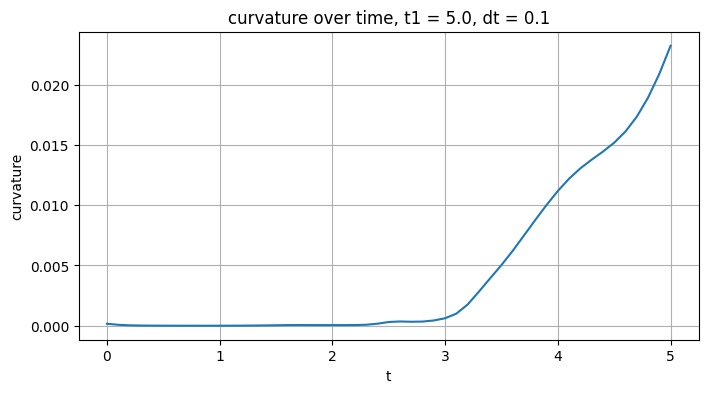

In [ ]:
args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "sigmoid",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)

print(f"activation: {args.activation}, dt = {args.dt}")

times = [1.0, 3.0, 5.0]
dts = [0.01, 0.05, 0.1]
for t1_ in times:
    args.t1 = t1_

    for dt_ in dts:
        args.dt = dt_
        best_model = load_best_model(args,experiments_dir=experiments_dir)

        N_steps = int(args.t1 / args.dt)
        ts = jnp.linspace(0.0, args.t1, N_steps + 1)

        X_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
        traj_length = trajectory_length(X_traj)
        traj_dir = trajectory_direction(X_traj)
        print(f"for t1 = {args.t1}:")
        print(f"traj_dir = {traj_dir}")
        print(f"traj_length = {traj_length}")

        kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

        plt.figure(figsize=(8, 4))
        plt.plot(ts, kappa)
        plt.xlabel("t")
        plt.ylabel("curvature")
        plt.title(f"curvature over time, t1 = {args.t1}, dt = {args.dt}")
        plt.grid(True)
        plt.show()

activation: tanh
for t1 = 5.0:
traj_dir = 3258.234130859375
traj_length = 3259.5322265625


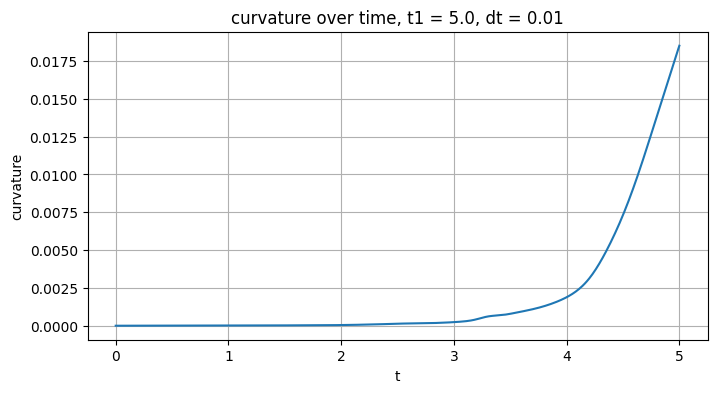

for t1 = 5.0:
traj_dir = 3257.6298828125
traj_length = 3258.875732421875


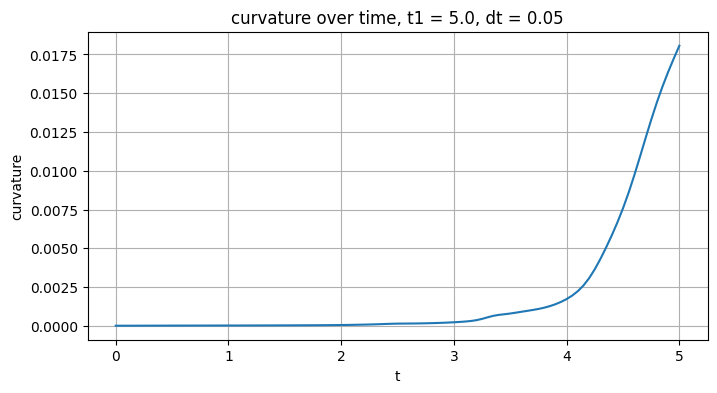

for t1 = 5.0:
traj_dir = 3258.15771484375
traj_length = 3259.373779296875


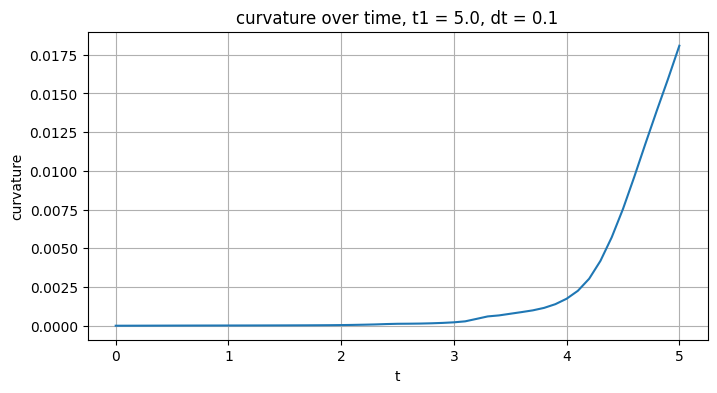

for t1 = 10.0:
traj_dir = 3283.030029296875
traj_length = 3295.614990234375


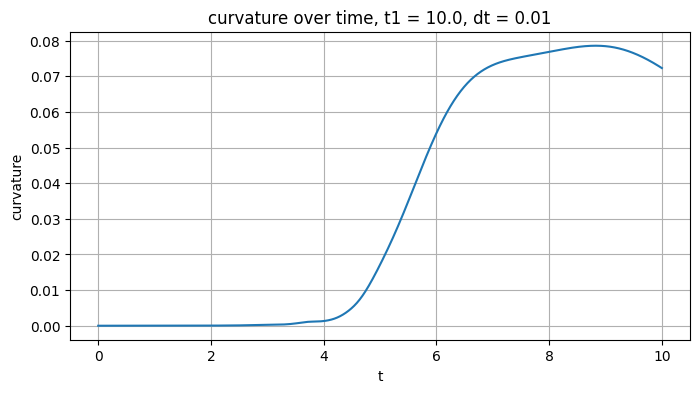

for t1 = 10.0:
traj_dir = 3283.455078125
traj_length = 3294.72412109375


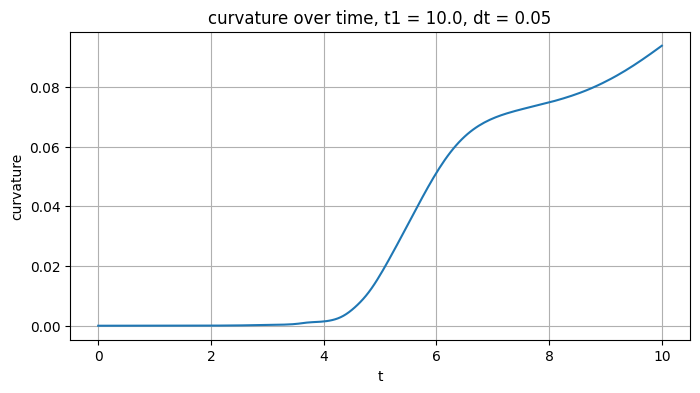

for t1 = 10.0:
traj_dir = 3283.48828125
traj_length = 3295.0849609375


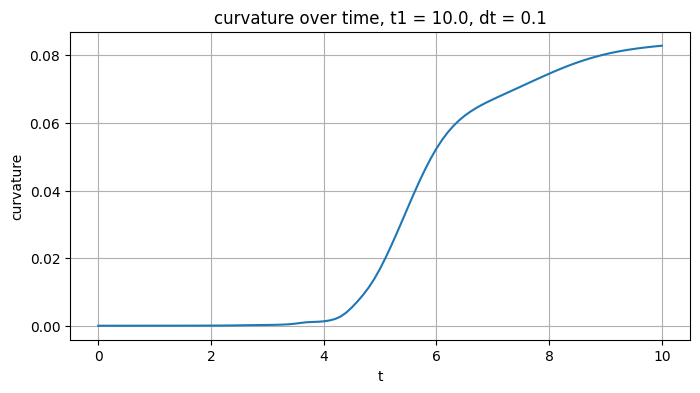

for t1 = 15.0:
traj_dir = 3285.14404296875
traj_length = 3302.800537109375


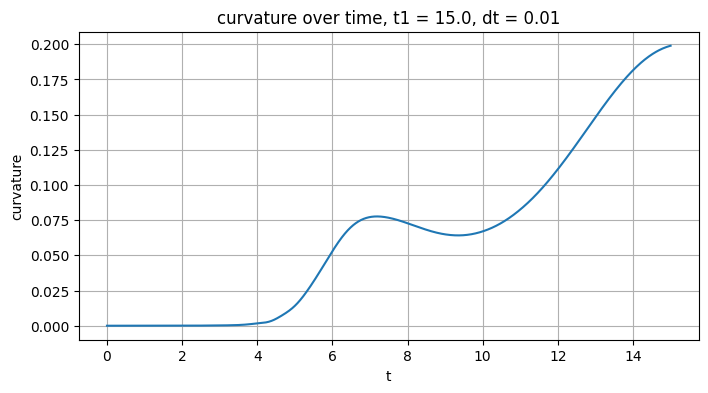

for t1 = 15.0:
traj_dir = 3286.379638671875
traj_length = 3304.366455078125


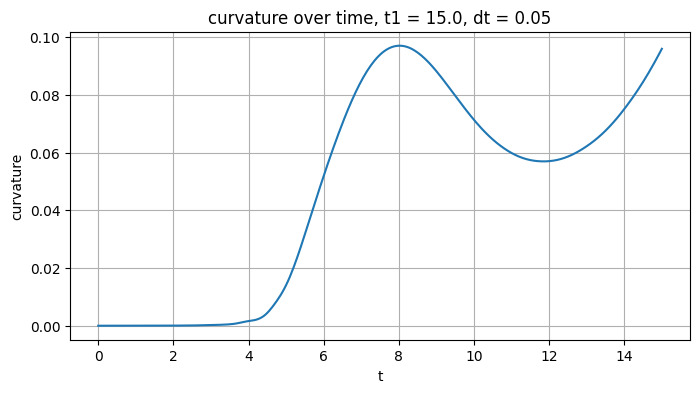

for t1 = 15.0:
traj_dir = 3285.14111328125
traj_length = 3301.458984375


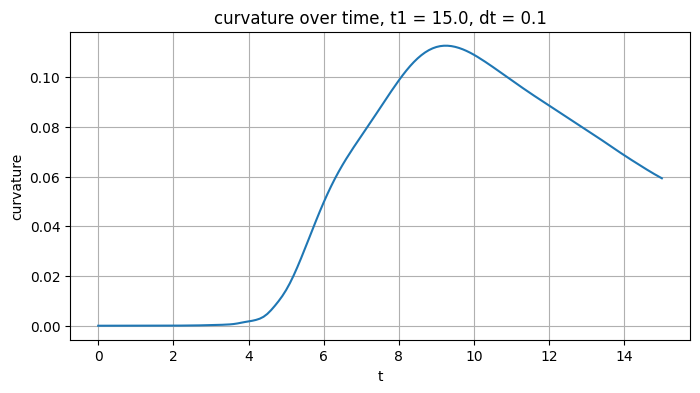

In [ ]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-4"

args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "tanh",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)

print(f"activation: {args.activation}")


times = [5.0, 10.0, 15.0]
dts = [0.01, 0.05, 0.1]
for t1_ in times:
    args.t1 = t1_

    for dt_ in dts:
        args.dt = dt_
        best_model = load_best_model(args,experiments_dir=experiments_dir)

        N_steps = int(args.t1 / args.dt)
        ts = jnp.linspace(0.0, args.t1, N_steps + 1)

        X_traj = integrate_trajectory(best_model, x_0, args.dt, args.t1, ts)
        traj_length = trajectory_length(X_traj)
        traj_dir = trajectory_direction(X_traj)
        print(f"for t1 = {args.t1}:")
        print(f"traj_dir = {traj_dir}")
        print(f"traj_length = {traj_length}")

        kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

        plt.figure(figsize=(8, 4))
        plt.plot(ts, kappa)
        plt.xlabel("t")
        plt.ylabel("curvature")
        plt.title(f"curvature over time, t1 = {args.t1}, dt = {args.dt}")
        plt.grid(True)
        plt.show()

In [ ]:
X, y = create_custom_batch(key,
                    numbers = [0,1,2,3,4,5,6,7,8,9],
                    each_number_samples=1)

activation: tanh, dt = 0.01, t1 = 15.0
for t1 = 15.0:
traj_dir = 1650.181640625
traj_length = 1664.97216796875


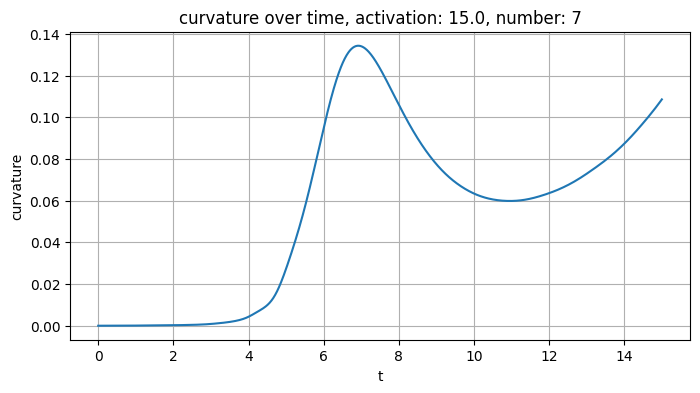

for t1 = 15.0:
traj_dir = 2105.402099609375
traj_length = 2118.324462890625


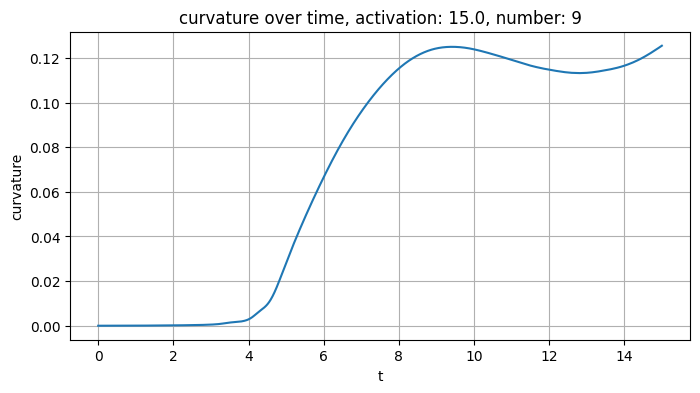

for t1 = 15.0:
traj_dir = 2270.704833984375
traj_length = 2290.04443359375


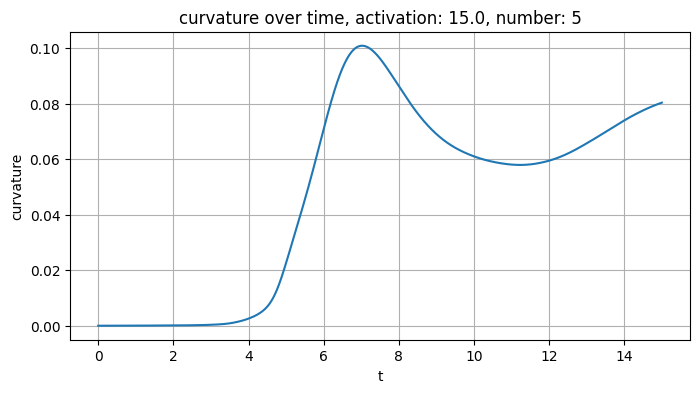

for t1 = 15.0:
traj_dir = 3158.8642578125
traj_length = 3176.130859375


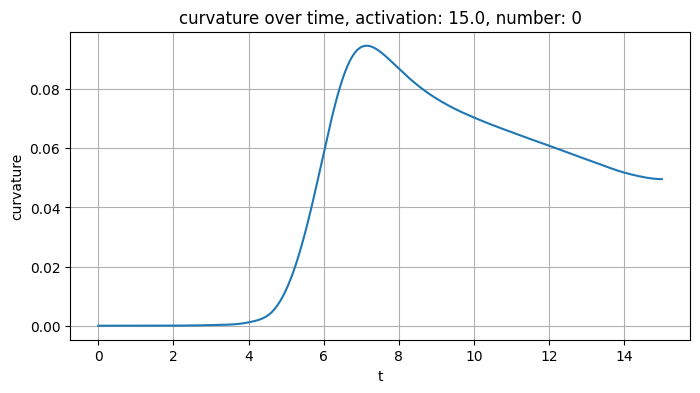

for t1 = 15.0:
traj_dir = 2314.13623046875
traj_length = 2331.654052734375


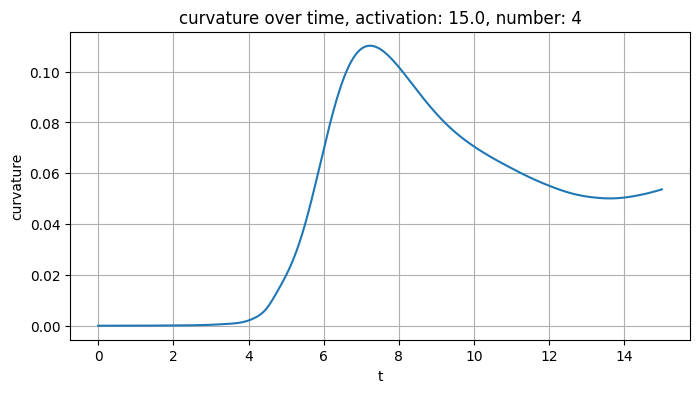

for t1 = 15.0:
traj_dir = 2117.563720703125
traj_length = 2133.1171875


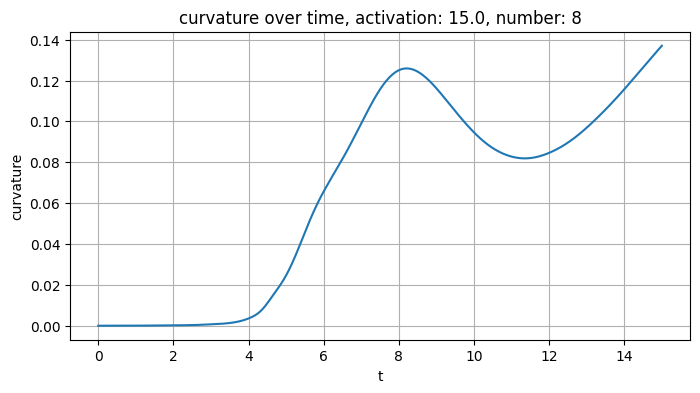

for t1 = 15.0:
traj_dir = 2374.080078125
traj_length = 2389.637939453125


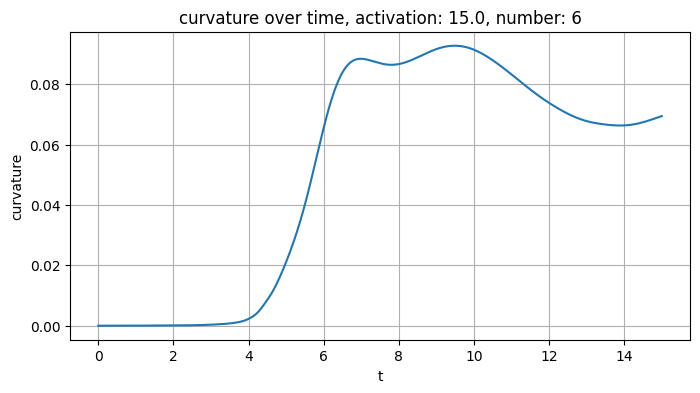

for t1 = 15.0:
traj_dir = 2254.27197265625
traj_length = 2272.876220703125


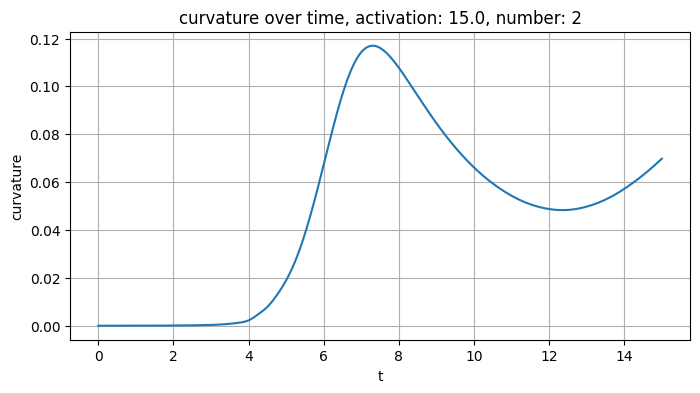

for t1 = 15.0:
traj_dir = 2881.90234375
traj_length = 2899.5283203125


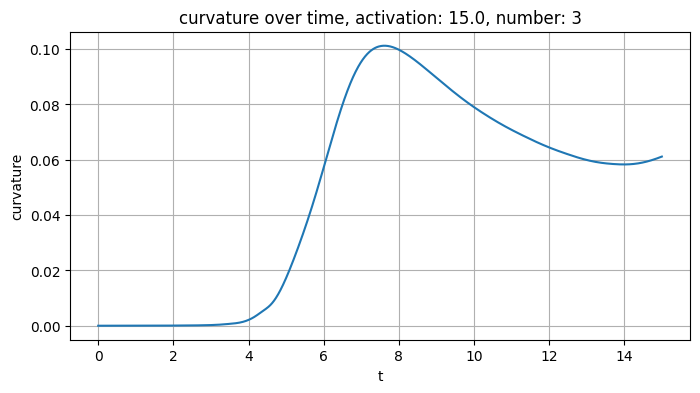

for t1 = 15.0:
traj_dir = 1792.7945556640625
traj_length = 1807.4200439453125


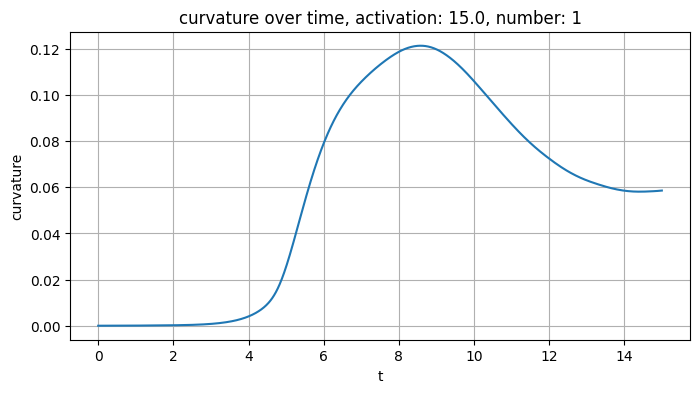

In [ ]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-4"

args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "tanh",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)
best_model = load_best_model(args,experiments_dir=experiments_dir)
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

print(f"activation: {args.activation}, dt = {args.dt}, t1 = {args.t1}")

for i in range(10):
    X_traj = integrate_trajectory(best_model, X[i], args.dt, args.t1, ts)
    traj_length = trajectory_length(X_traj)
    traj_dir = trajectory_direction(X_traj)
    print(f"for t1 = {args.t1}:")
    print(f"traj_dir = {traj_dir}")
    print(f"traj_length = {traj_length}")

    kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

    plt.figure(figsize=(8, 4))
    plt.plot(ts, kappa)
    plt.xlabel("t")
    plt.ylabel("curvature")
    plt.title(f"curvature over time, activation: {args.t1}, number: {y[i]}")
    plt.grid(True)
    plt.show()

activation: relu, dt = 0.01, t1 = 15.0
for t1 = 15.0:
traj_dir = 1960.3765869140625
traj_length = 4431.36376953125


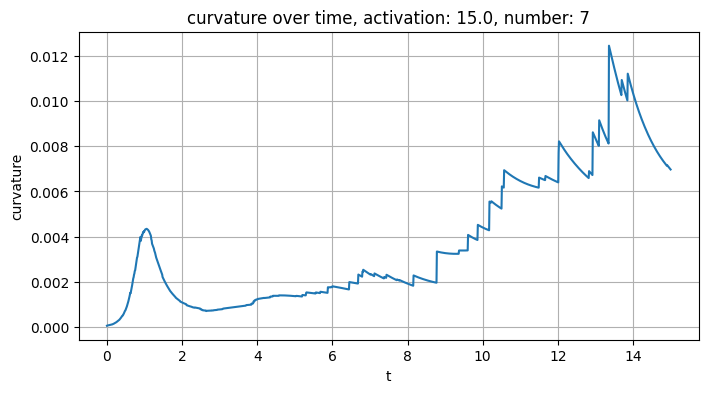

for t1 = 15.0:
traj_dir = 2374.0908203125
traj_length = 5175.77099609375


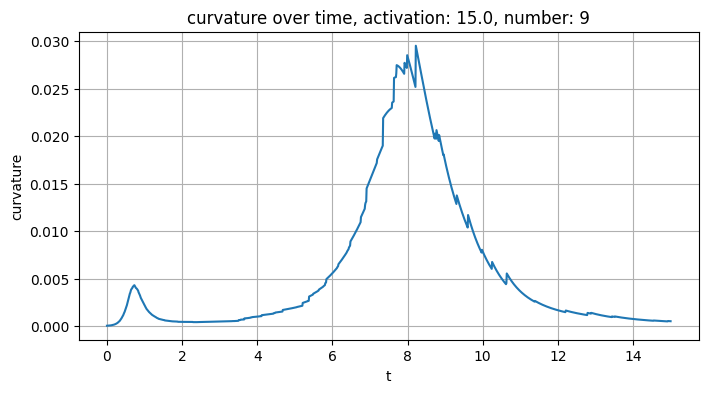

for t1 = 15.0:
traj_dir = 7063.54052734375
traj_length = 9665.12109375


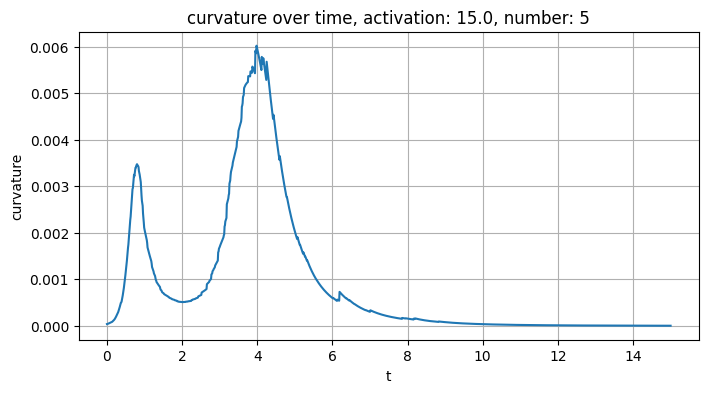

for t1 = 15.0:
traj_dir = 3445.7265625
traj_length = 7583.052734375


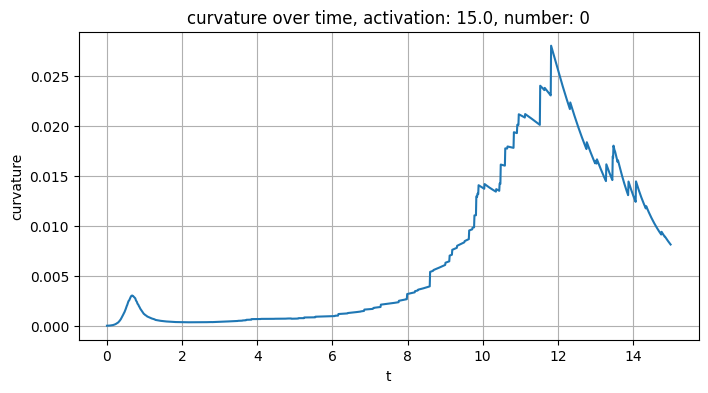

for t1 = 15.0:
traj_dir = 2431.472900390625
traj_length = 5990.6162109375


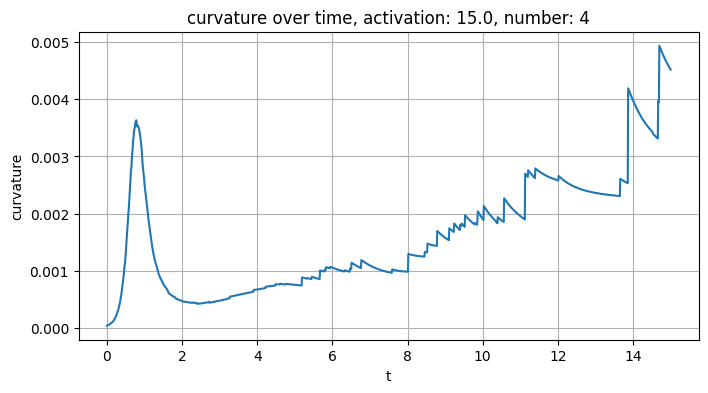

for t1 = 15.0:
traj_dir = 2186.865478515625
traj_length = 5054.00537109375


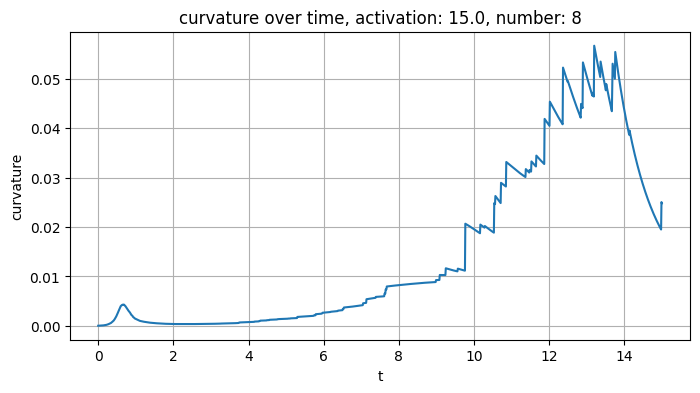

for t1 = 15.0:
traj_dir = 3032.432861328125
traj_length = 5952.27197265625


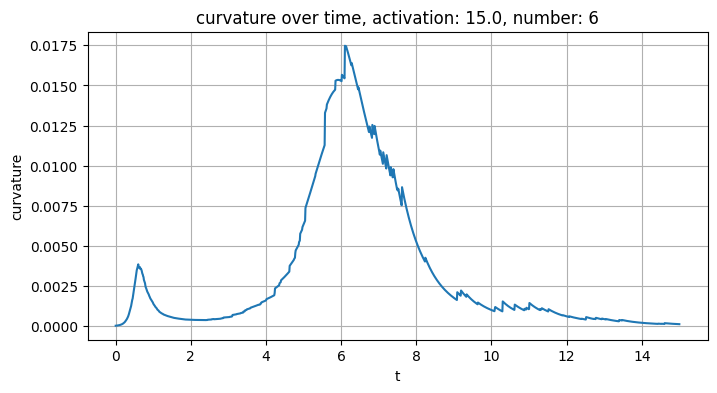

for t1 = 15.0:
traj_dir = 2678.8271484375
traj_length = 5566.8671875


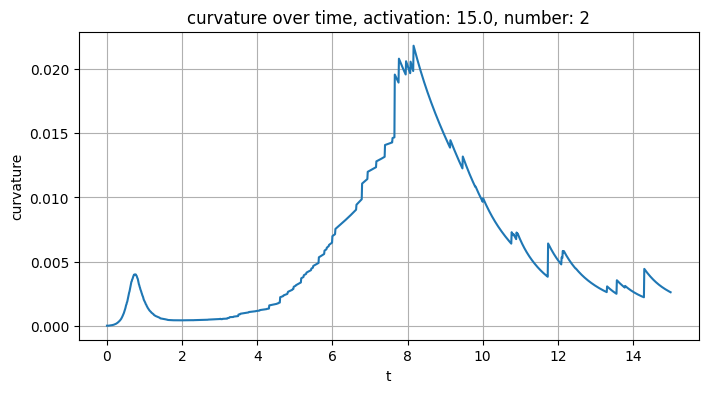

for t1 = 15.0:
traj_dir = 3033.42626953125
traj_length = 7108.28515625


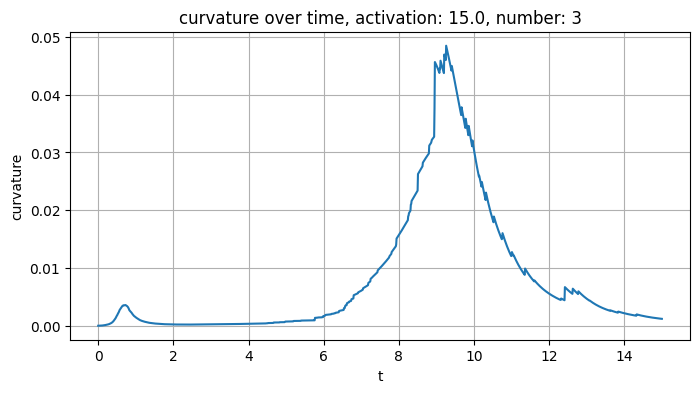

for t1 = 15.0:
traj_dir = 11028.8232421875
traj_length = 12671.4951171875


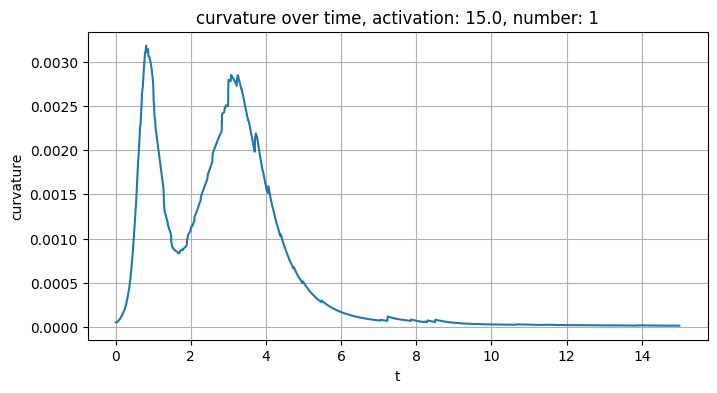

In [ ]:
experiments_dir = "/content/drive/MyDrive/HopfieldAM_experiments/experiments_lr_e-3"

args = Namespace(
    model="Hopfield",
    loss="loss_last10",
    dataset_name = "mnist",
    batch_size=128,
    activation = "relu",
    dt=0.01,
    t1=15.0,
    N_classes=10,
)
best_model = load_best_model(args,experiments_dir=experiments_dir)
N_steps = int(args.t1 / args.dt)
ts = jnp.linspace(0.0, args.t1, N_steps + 1)

print(f"activation: {args.activation}, dt = {args.dt}, t1 = {args.t1}")

for i in range(10):
    X_traj = integrate_trajectory(best_model, X[i], args.dt, args.t1, ts)
    traj_length = trajectory_length(X_traj)
    traj_dir = trajectory_direction(X_traj)
    print(f"for t1 = {args.t1}:")
    print(f"traj_dir = {traj_dir}")
    print(f"traj_length = {traj_length}")

    kappa = derivative_based_curvature_(best_model, X_traj, args.dt, args.t1)

    plt.figure(figsize=(8, 4))
    plt.plot(ts, kappa)
    plt.xlabel("t")
    plt.ylabel("curvature")
    plt.title(f"curvature over time, activation: {args.t1}, number: {y[i]}")
    plt.grid(True)
    plt.show()